# Model regresji: przewidywanie `Life expectancy`

**Przedmiot:** Metody Eksploracji Danych

**Autorzy:** Stanisław Dutkiewicz, Paweł Myszka, Łukasz Jugo

**Grupa 6**

**Data:** 22 grudnia 2025

Cel: zbudować i ocenić model regresji przewidujący oczekiwaną długość życia (*Life expectancy*) na podstawie zmiennych zdrowotnych, ekonomicznych i społecznych z pliku CSV.

Notebook prowadzi krok po kroku:
1) wczytanie danych, 2) kontrola braków i typów, 3) przygotowanie danych (uzupełnianie braków, standaryzacja, kodowanie `Status`), 4) dobór cech, 5) modele liniowe + regularyzacja (Ridge), 6) walidacja i analiza błędów, 7) interpretacja (permutacja), 8) zapis modelu.

Założenie (domyślne): **nie używamy `Country` jako cechy**, żeby uniknąć “identyfikowania kraju” i przeuczenia; zostawiamy `Year`, `Status` i pozostałe zmienne numeryczne.

In [1]:
# 1) Ustawienia środowiska i import bibliotek
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge

# Ustawienia czytelności
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid")

print("OK: biblioteki załadowane")
print("Wskazówka: jeśli brakuje scikit-learn, doinstaluj: pip install scikit-learn")

OK: biblioteki załadowane
Wskazówka: jeśli brakuje scikit-learn, doinstaluj: pip install scikit-learn


## 2) Wczytanie CSV i szybka walidacja danych

Uwaga: w oryginalnym zbiorze zdarzają się spacje na końcu nazw kolumn (np. `Life expectancy `). Poniżej **czyścimy nazwy kolumn** przez `.str.strip()` i dopiero potem wybieramy target.

In [2]:
# 2) Wczytanie CSV i szybka walidacja danych

CSV_PATH = Path("Life Expectancy Data.csv")  # plik jest w katalogu projektu

if not CSV_PATH.exists():
    raise FileNotFoundError(f"Nie znaleziono pliku: {CSV_PATH.resolve()}")

df = pd.read_csv(CSV_PATH)

# standaryzacja nazw kolumn (w zbiorze zdarzają się spacje na końcu)
df.columns = df.columns.str.strip()

print("Wczytano df:")
print("- shape:", df.shape)
display(df.head())

# szybka sanity-check
print("\nKolumny:", list(df.columns))
print("\nPrzykładowe kraje:", df["Country"].dropna().unique()[:5])
print("Zakres lat:", df["Year"].min(), "-", df["Year"].max())

Wczytano df:
- shape: (2938, 22)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5



Kolumny: ['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']

Przykładowe kraje: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda']
Zakres lat: 2000 - 2015


## 3) Podgląd struktury: typy kolumn, braki danych, duplikaty

W tym kroku:
- sprawdzamy typy kolumn,
- liczymy braki danych (procentowo),
- sprawdzamy duplikaty,
- robimy prosty wykres procentu braków.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None


Kolumny z brakami (top 15):


,missing_%,missing_count
Population,22.19,652
Hepatitis B,18.82,553
GDP,15.25,448
Total expenditure,7.69,226
Alcohol,6.60,194
Income composition of resources,5.68,167
Schooling,5.55,163
thinness 5-9 years,1.16,34
thinness 1-19 years,1.16,34
BMI,1.16,34



Duplikaty wierszy: 0

Kolumny kategoryczne: ['Country', 'Status']
- Country: 193 unikalnych wartości
- Status: 2 unikalnych wartości


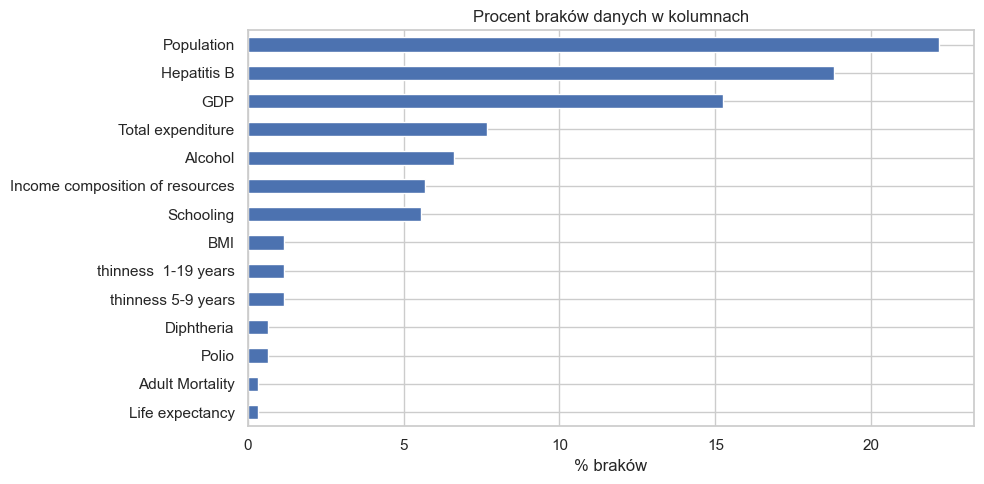

In [3]:
# 3) Typy, braki, duplikaty

display(df.info())

missing_frac = df.isna().mean().sort_values(ascending=False)
missing_tbl = (missing_frac * 100).round(2).to_frame("missing_%")
missing_tbl["missing_count"] = df.isna().sum()
missing_tbl = missing_tbl[missing_tbl["missing_count"] > 0]

print("\nKolumny z brakami (top 15):")
display(missing_tbl.head(15))

dup_count = df.duplicated().sum()
print(f"\nDuplikaty wierszy: {dup_count}")

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("\nKolumny kategoryczne:", cat_cols)
for c in cat_cols:
    print(f"- {c}: {df[c].nunique(dropna=True)} unikalnych wartości")

# wykres procentu braków
if len(missing_tbl) > 0:
    plt.figure(figsize=(10, 5))
    missing_tbl["missing_%"].sort_values(ascending=True).plot(kind="barh")
    plt.title("Procent braków danych w kolumnach")
    plt.xlabel("% braków")
    plt.tight_layout()
    plt.show()

## Braki danych: co z nimi robimy?

W eksploracyjnej analizie danych wyszło, że usunięcie wierszy z brakami wycina ~44% danych i może biasować próbę (kraje z lepszą sprawozdawczością). Dlatego tutaj:

- **Nie usuwamy wierszy** z brakami w cechach (poza brakami w samym `y`).
- Uzupełniamy braki w danych w prosty sposób:
  - kolumny liczbowe → **mediana**,
  - `Status` → **najczęstsza wartość** + zamiana na kolumny 0/1 (One-Hot).

Opcjonalnie (zgodnie z narracją z eksploracyjnej analizy danych o "wartościach z lat poprzednich"): można zrobić uzupełnianie **w obrębie kraju po czasie** (forward-fill/back-fill). To ma sens, ale trzeba uważać na wyciek informacji; jeśli chcesz, zrobimy to jako osobny eksperyment (train i test osobno).

In [4]:
def country_time_impute(frame: pd.DataFrame, numeric_columns: list[str]) -> pd.DataFrame:
    out = frame.copy()
    if "Country" not in out.columns or "Year" not in out.columns:
        return out

    out = out.sort_values(["Country", "Year"]).reset_index(drop=True)

    # forward-fill i backward-fill w obrębie kraju
    out[numeric_columns] = (
        out.groupby("Country", as_index=False)[numeric_columns]
           .apply(lambda g: g.ffill().bfill())
           .reset_index(drop=True)
    )

    return out

print("OK: helper country_time_impute() gotowy (opcjonalny)")

OK: helper country_time_impute() gotowy (opcjonalny)


## 4) Wybór zmiennej celu (target) i podział na X/y

Zmienna celu: **`Life expectancy`**.

Zgodnie z eksploracyjną analizą danych: **nie używamy `Country` jako cechy** (żeby nie robić modelu „rozpoznaj kraj"). `Country` zostaje tylko jako ewentualny klucz do analiz/eksperymentów z imputacją po czasie.

In [5]:
# 4) Target oraz X/y

TARGET_COL = "Life expectancy"

if TARGET_COL not in df.columns:
    raise KeyError(f"Nie ma kolumny targetu '{TARGET_COL}'. Dostępne: {list(df.columns)}")

# y musi być liczbowe
y = pd.to_numeric(df[TARGET_COL], errors="coerce")

# X: wszystkie kolumny poza targetem, ale bez Country
DROP_COLS = ["Country"]
X = df.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in df.columns])

print("X shape:", X.shape)
print("y shape:", y.shape)

# szybki podgląd
print("\nX dtypes (top 10):")
print(X.dtypes.head(10))
print("\ny missing %:", round(y.isna().mean() * 100, 2))

X shape: (2938, 20)
y shape: (2938,)

X dtypes (top 10):
Year                        int64
Status                     object
Adult Mortality           float64
infant deaths               int64
Alcohol                   float64
percentage expenditure    float64
Hepatitis B               float64
Measles                     int64
BMI                       float64
under-five deaths           int64
dtype: object

y missing %: 0.34


## 5) Podział train/test (z kontrolą losowości)

Żeby porównywać modele uczciwie, robimy stały podział `train_test_split`.

Opcjonalnie: przy mocno skośnym rozkładzie targetu można robić pseudo-stratyfikację po binach `y` (tu robimy to „best-effort”: jeśli się nie da, wracamy do zwykłego split).

In [6]:
# 5) train/test split

# Best-effort stratyfikacja po binach y (jeśli się da)
stratify_labels = None
try:
    y_bins = pd.qcut(y, q=10, duplicates="drop")
    if y_bins.nunique() >= 2 and y_bins.notna().all():
        stratify_labels = y_bins
except Exception:
    stratify_labels = None

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=stratify_labels,
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("y_train missing %:", round(y_train.isna().mean() * 100, 2))
print("y_test missing %:", round(y_test.isna().mean() * 100, 2))

# Jeśli target ma braki, usuwamy je TYLKO z y i odpowiadających wierszy X w danym zbiorze.
train_mask = y_train.notna()
test_mask = y_test.notna()
X_train = X_train.loc[train_mask]
y_train = y_train.loc[train_mask]
X_test = X_test.loc[test_mask]
y_test = y_test.loc[test_mask]

print("Po usunięciu braków w y:")
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (2350, 20) Test: (588, 20)
y_train missing %: 0.34
y_test missing %: 0.34
Po usunięciu braków w y:
Train: (2342, 20) Test: (586, 20)


## 6) Przygotowanie danych: uzupełnianie braków + standaryzacja + kodowanie `Status`

W tym kroku przygotowujemy dane do uczenia modelu:
- kolumny liczbowe: uzupełnienie braków (mediana) i standaryzacja,
- `Status`: uzupełnienie braków (najczęstsza wartość) i kodowanie One-Hot.

Ważne: transformacje „uczymy” tylko na zbiorze treningowym i stosujemy je do zbioru testowego, żeby nie mieszać informacji z testu do treningu.

In [7]:
# 6) Przygotowanie danych (ręczne fit/transform)

# Identyfikacja kolumn
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

# W tym zbiorze sensownie zostawić tylko Status jako cechę kategoryczną
categorical_features = [c for c in categorical_features if c == "Status"]

print("Numeryczne:", numeric_features)
print("Kategoryczne:", categorical_features)

# Obiekty przygotowania danych
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

cat_imputer = SimpleImputer(strategy="most_frequent")

# OneHotEncoder: kompatybilność między wersjami sklearn (sparse vs sparse_output)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

def fit_preprocess(X_train: pd.DataFrame) -> dict:
    """Dopasuj obiekty przygotowania danych na zbiorze treningowym."""
    bundle = {}

    # numeryczne
    bundle["numeric_features"] = numeric_features
    bundle["num_imputer"] = num_imputer.fit(X_train[numeric_features])
    X_num = bundle["num_imputer"].transform(X_train[numeric_features])
    bundle["scaler"] = scaler.fit(X_num)

    # kategoryczne (Status)
    bundle["categorical_features"] = categorical_features
    if len(categorical_features) > 0:
        bundle["cat_imputer"] = cat_imputer.fit(X_train[categorical_features])
        X_cat = bundle["cat_imputer"].transform(X_train[categorical_features])
        bundle["ohe"] = ohe.fit(X_cat)
    else:
        bundle["cat_imputer"] = None
        bundle["ohe"] = None

    # nazwy cech po transformacji
    num_names = np.array(numeric_features, dtype=object)
    if bundle["ohe"] is not None:
        try:
            cat_names = bundle["ohe"].get_feature_names_out(categorical_features).astype(object)
        except Exception:
            cat_names = np.array([], dtype=object)
    else:
        cat_names = np.array([], dtype=object)
    bundle["feature_names"] = np.concatenate([num_names, cat_names])

    return bundle

def transform_preprocess(bundle: dict, X: pd.DataFrame) -> np.ndarray:
    """Zastosuj przygotowanie danych: imputacja + skalowanie + OneHot."""
    # numeryczne
    X_num = bundle["num_imputer"].transform(X[bundle["numeric_features"]])
    X_num = bundle["scaler"].transform(X_num)

    # kategoryczne
    if bundle.get("ohe") is not None and len(bundle.get("categorical_features", [])) > 0:
        X_cat = bundle["cat_imputer"].transform(X[bundle["categorical_features"]])
        X_cat = bundle["ohe"].transform(X_cat)
    else:
        X_cat = np.empty((len(X), 0))

    X_t = np.hstack([X_num, X_cat])

    # (opcjonalnie) dobór cech
    if "selector" in bundle:
        X_t = bundle["selector"].transform(X_t)

    return X_t

preprocess_bundle = fit_preprocess(X_train)
X_train_t = transform_preprocess(preprocess_bundle, X_train)
X_test_t = transform_preprocess(preprocess_bundle, X_test)

print("OK: przygotowanie danych gotowe")
print("- X_train_t:", X_train_t.shape)
print("- X_test_t:", X_test_t.shape)

Numeryczne: ['Year', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']
Kategoryczne: ['Status']
OK: przygotowanie danych gotowe
- X_train_t: (2342, 21)
- X_test_t: (586, 21)


## 7) Dobór cech: SelectKBest (f_regression)

Wymaganie projektu obejmuje dobór cech. Ponieważ po przygotowaniu danych mamy już macierz cech (`X_train_t`), wykonujemy dobór cech wyłącznie na zbiorze treningowym i stosujemy go na teście.

Metoda: `SelectKBest` z testem `f_regression` (univariate) – wybiera cechy o najsilniejszym związku liniowym z targetem.

In [8]:
# 7) Dobór cech – SelectKBest
from sklearn.feature_selection import SelectKBest, f_regression

# Ustal liczbę wybieranych cech (prosty, rozsądny wybór do raportu)
k = min(20, X_train_t.shape[1])
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X_train_t, y_train)

# Zastosuj dobór cech
X_train_t_fs = selector.transform(X_train_t)
X_test_t_fs = selector.transform(X_test_t)

selected_mask = selector.get_support()
selected_feature_names = preprocess_bundle["feature_names"][selected_mask]

# Podłączamy selector do bundle (żeby zapisany model dało się używać)
preprocess_bundle["selector"] = selector
preprocess_bundle["feature_names"] = selected_feature_names

# Dla dalszych kroków pracujemy już na macierzy po doborze cech
X_train_t = X_train_t_fs
X_test_t = X_test_t_fs

print("OK: dobór cech")
print("- k:", k)
print("- X_train_t:", X_train_t.shape)
print("- X_test_t:", X_test_t.shape)
display(pd.DataFrame({"feature": selected_feature_names}).head(20))

OK: dobór cech
- k: 20
- X_train_t: (2342, 20)
- X_test_t: (586, 20)


,feature
0,Year
1,Adult Mortality
2,infant deaths
3,Alcohol
4,percentage expenditure
5,Hepatitis B
6,Measles
7,BMI
8,under-five deaths
9,Polio


## 8) Funkcja ewaluacji (MAE / RMSE / $R^2$)

Dalej trenujemy modele na danych po preprocessingu (`X_train_t`, `X_test_t`).

In [9]:
# 8) Ewaluacja – bez Pipeline

def evaluate_estimator(model, X_train_t, X_test_t, y_train, y_test, name: str) -> dict:
    model.fit(X_train_t, y_train)
    y_pred = model.predict(X_test_t)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }

results = []
print("OK: evaluate_estimator() gotowa")

OK: evaluate_estimator() gotowa


## 8) Modele: dlaczego takie?

Wybór modeli opiera się na wnioskach z eksploracyjnej analizy danych:

- **Zależności są w dużej mierze liniowe** (korelacje + wykresy punktowe), więc startujemy od **regresji liniowej**.
- Jest sporo **współzależnych cech** (np. szczepienia korelują), co może destabilizować współczynniki w czystej regresji liniowej.
- Dlatego jako model „docelowy” bierzemy **Ridge Regression (L2)** – nadal liniowy, ale bardziej stabilny.

Nie używamy `Pipeline`: preprocessing robimy osobno (fit na train → transform train/test), a modele trenujemy na macierzy cech po transformacji.

In [10]:
# 8) LinearRegression + Ridge (z tuningiem) – bez sklearn.Pipeline

# LinearRegression
lin_model = LinearRegression()
results.append(evaluate_estimator(lin_model, X_train_t, X_test_t, y_train, y_test, "LinearRegression"))

# Ridge z GridSearchCV (na danych po preprocessingu)
ridge = Ridge(random_state=RANDOM_STATE)
param_grid = {"alpha": np.logspace(-3, 3, 13)}

ridge_search = GridSearchCV(
    ridge,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
 )

ridge_search.fit(X_train_t, y_train)
print("Ridge best params:", ridge_search.best_params_)

ridge_best = ridge_search.best_estimator_
results.append(evaluate_estimator(ridge_best, X_train_t, X_test_t, y_train, y_test, "Ridge(best alpha)"))

results_df = pd.DataFrame(results).sort_values("RMSE")
display(results_df)

Ridge best params: {'alpha': 0.001}


,model,MAE,RMSE,R2
0,LinearRegression,2.844965,3.889197,0.826001
1,Ridge(best alpha),2.844966,3.889201,0.826001


## 10) Walidacja krzyżowa i raport metryk

Walidacja krzyżowa (np. 5-fold) pozwala sprawdzić stabilność wyniku.

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$$

In [11]:
# 11) Cross-validation dla najlepszego modelu (wg RMSE na teście) – bez pipeline

best_name = results_df.iloc[0]["model"]
print("Najlepszy wg RMSE (test):", best_name)

if best_name.startswith("Ridge"):
    best_model = ridge_best
else:
    best_model = lin_model

scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_root_mean_squared_error",
    "R2": "r2",
}

cv = cross_validate(
    best_model,
    X_train_t,
    y_train,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False,
 )

cv_summary = pd.DataFrame(
    {
        "MAE": -cv["test_MAE"],
        "RMSE": -cv["test_RMSE"],
        "R2": cv["test_R2"],
    },
)

print("\nCV (5-fold) – średnia ± odch. std:")
for metric in ["MAE", "RMSE", "R2"]:
    print(f"- {metric}: {cv_summary[metric].mean():.4f} ± {cv_summary[metric].std():.4f}")

display(cv_summary)

Najlepszy wg RMSE (test): LinearRegression

CV (5-fold) – średnia ± odch. std:
- MAE: 3.0813 ± 0.0713
- RMSE: 4.1297 ± 0.1482
- R2: 0.8120 ± 0.0199


,MAE,RMSE,R2
0,3.125848,4.223737,0.820832
1,3.038828,3.929337,0.837241
2,3.063892,4.202004,0.787914
3,3.178734,4.275166,0.795945
4,2.999288,4.018238,0.818101


## 11) Analiza błędów: $y_{true}$ vs $y_{pred}$ i reszty

Wykresy pozwalają szybko sprawdzić:
- czy błąd rośnie dla pewnych zakresów (heteroscedastyczność),
- czy są obserwacje odstające,
- czy model ma bias (systematyczne przeszacowanie/niedoszacowanie).

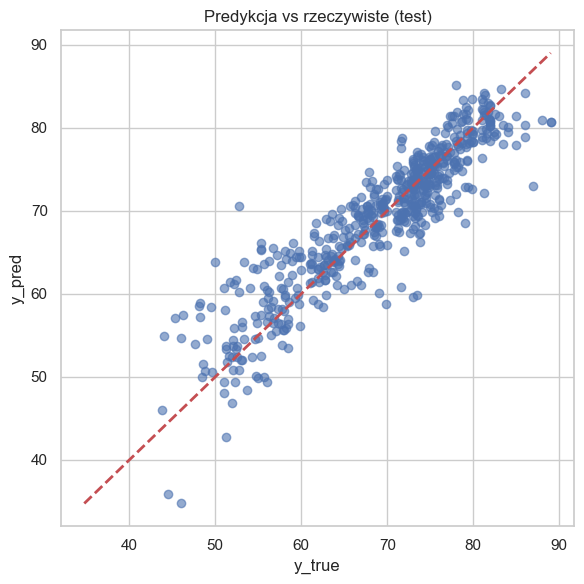

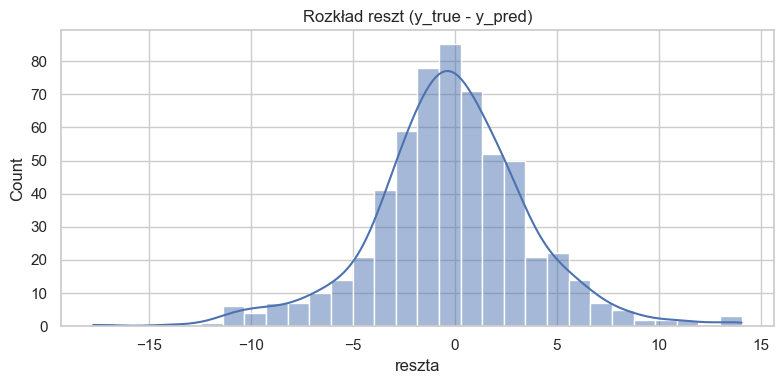

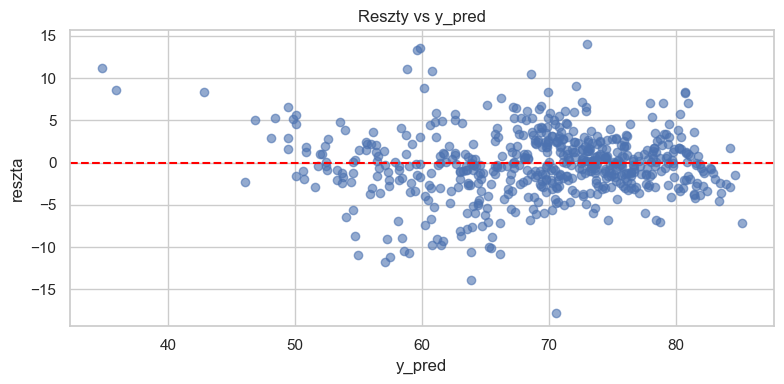

Reszty: średnia= -0.2206816524109867 std= 3.8829306632618215


In [12]:
# 11) Wykresy błędów na teście (bez pipeline)

best_model.fit(X_train_t, y_train)
y_pred = best_model.predict(X_test_t)
residuals = y_test - y_pred

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("Predykcja vs rzeczywiste (test)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Rozkład reszt (y_true - y_pred)")
plt.xlabel("reszta")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Reszty vs y_pred")
plt.xlabel("y_pred")
plt.ylabel("reszta")
plt.tight_layout()
plt.show()

print("Reszty: średnia=", float(np.mean(residuals)), "std=", float(np.std(residuals)))

## 12) Ważność cech (Permutation Importance)

Ważność cech liczymy przez permutację na zbiorze testowym:
- mieszamy jedną kolumnę w `X_test_t`,
- patrzymy, jak bardzo pogarsza się wynik (tu: RMSE).

To działa dla modeli liniowych i nieliniowych.

,feature,importance_mean,importance_std
8,under-five deaths,15.456778,0.820151
2,infant deaths,15.306660,0.680917
1,Adult Mortality,1.212866,0.107740
17,Schooling,1.021826,0.088446
12,HIV/AIDS,0.863950,0.097815
16,Income composition of resources,0.332177,0.060261
11,Diphtheria,0.290442,0.028963
7,BMI,0.172835,0.019933
9,Polio,0.142246,0.022651
13,GDP,0.064364,0.025940


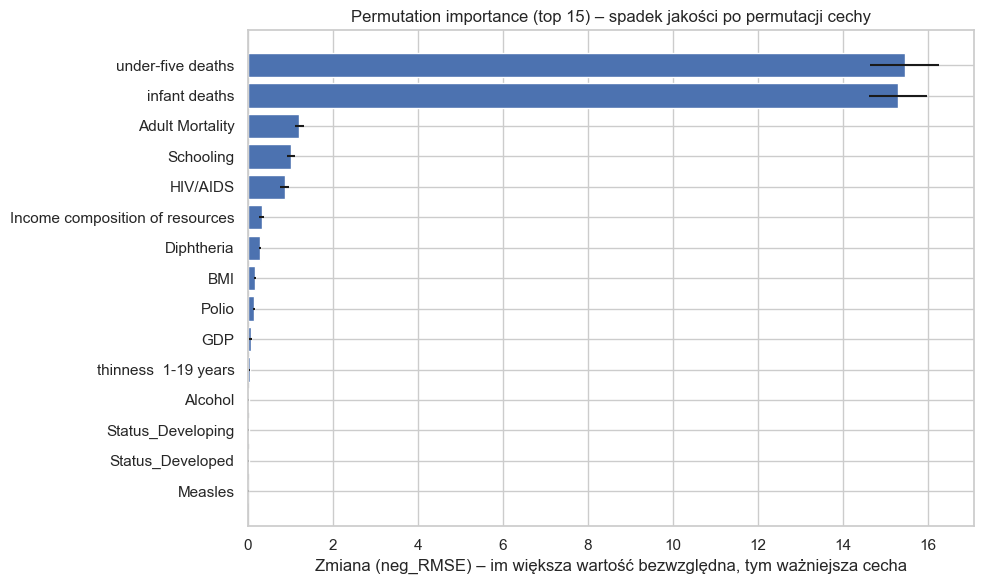

In [13]:
# 12) Permutation importance (bez pipeline)
from sklearn.inspection import permutation_importance

# dopasuj najlepszy model na train
best_model.fit(X_train_t, y_train)

# nazwy cech po preprocessingu (z naszego "ręcznego" preprocessu)
feature_names = np.array(preprocess_bundle.get("feature_names", []), dtype=object)

perm = permutation_importance(
    best_model,
    X_test_t,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error",
)

importances = pd.DataFrame(
    {
        "feature": feature_names,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std,
    }
).sort_values("importance_mean", ascending=False)

display(importances.head(20))

plt.figure(figsize=(10, 6))
topk = importances.head(15).iloc[::-1]
plt.barh(topk["feature"], topk["importance_mean"], xerr=topk["importance_std"])
plt.title("Permutation importance (top 15) – spadek jakości po permutacji cechy")
plt.xlabel("Zmiana (neg_RMSE) – im większa wartość bezwzględna, tym ważniejsza cecha")
plt.tight_layout()
plt.show()

## 14) Sprawdzenie uogólniania: podział po krajach (Country-holdout)

W eksploracyjnej analizie danych dane są w układzie **kraj–rok**. Przy losowym podziale wierszy ten sam kraj trafia do train i test, co często **zawyża wynik**.

Dlatego robimy dodatkowy test: trenujemy na części krajów i testujemy na *innych* krajach. To mówi, jak model działa na „nowych” państwach.

In [14]:
# 15) Country-holdout (bez Pipeline)

# przygotuj pełne X/y + grupy
_df = df.copy()
_df.columns = _df.columns.str.strip()

# target
_y_all = pd.to_numeric(_df[TARGET_COL], errors="coerce")

# cechy bez Country
_X_all = _df.drop(columns=[TARGET_COL, "Country"], errors="ignore")

# usuń braki w y
mask_all = _y_all.notna()
_X_all = _X_all.loc[mask_all].reset_index(drop=True)
_y_all = _y_all.loc[mask_all].reset_index(drop=True)
_groups = _df.loc[mask_all, "Country"].reset_index(drop=True)

countries = _groups.unique()
rng = np.random.RandomState(RANDOM_STATE)
rng.shuffle(countries)

cut = int(0.8 * len(countries))
train_countries = set(countries[:cut])

is_train = _groups.isin(train_countries)

X_train_c = _X_all.loc[is_train].reset_index(drop=True)
y_train_c = _y_all.loc[is_train].reset_index(drop=True)
X_test_c = _X_all.loc[~is_train].reset_index(drop=True)
y_test_c = _y_all.loc[~is_train].reset_index(drop=True)

print("Country-holdout:")
print("- train rows:", X_train_c.shape, "test rows:", X_test_c.shape)
print("- train countries:", len(train_countries), "test countries:", len(countries) - len(train_countries))

# dopasuj preprocess na train_c
numeric_features_c = X_train_c.select_dtypes(include=["number"]).columns.tolist()
categorical_features_c = [c for c in X_train_c.select_dtypes(include=["object"]).columns.tolist() if c == "Status"]

num_imputer_c = SimpleImputer(strategy="median")
scaler_c = StandardScaler()
cat_imputer_c = SimpleImputer(strategy="most_frequent")
try:
    ohe_c = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe_c = OneHotEncoder(handle_unknown="ignore", sparse=False)

# fit
Xtr_num = scaler_c.fit_transform(num_imputer_c.fit_transform(X_train_c[numeric_features_c]))
Xte_num = scaler_c.transform(num_imputer_c.transform(X_test_c[numeric_features_c]))

if len(categorical_features_c) > 0:
    Xtr_cat = ohe_c.fit_transform(cat_imputer_c.fit_transform(X_train_c[categorical_features_c]))
    Xte_cat = ohe_c.transform(cat_imputer_c.transform(X_test_c[categorical_features_c]))
else:
    Xtr_cat = np.empty((len(X_train_c), 0))
    Xte_cat = np.empty((len(X_test_c), 0))

X_train_ct = np.hstack([Xtr_num, Xtr_cat])
X_test_ct = np.hstack([Xte_num, Xte_cat])

# (opcjonalnie) ten sam dobór cech co w głównym eksperymencie
k_ct = min(k, X_train_ct.shape[1]) if "k" in globals() else min(20, X_train_ct.shape[1])
selector_ct = SelectKBest(score_func=f_regression, k=k_ct)
selector_ct.fit(X_train_ct, y_train_c)
X_train_ct = selector_ct.transform(X_train_ct)
X_test_ct = selector_ct.transform(X_test_ct)

# porównanie modeli na country-holdout (liniowe + regularizacja)
country_results = []
country_results.append(evaluate_estimator(LinearRegression(), X_train_ct, X_test_ct, y_train_c, y_test_c, "LinearRegression"))

ridge_c = GridSearchCV(
    Ridge(random_state=RANDOM_STATE),
    param_grid={"alpha": np.logspace(-3, 3, 13)},
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
)
ridge_c.fit(X_train_ct, y_train_c)
country_results.append(evaluate_estimator(ridge_c.best_estimator_, X_train_ct, X_test_ct, y_train_c, y_test_c, f"Ridge(alpha={ridge_c.best_params_['alpha']})"))

display(pd.DataFrame(country_results).sort_values("RMSE"))

Country-holdout:
- train rows: (2336, 20) test rows: (592, 20)
- train countries: 146 test countries: 37


,model,MAE,RMSE,R2
0,LinearRegression,3.373654,4.345982,0.801049
1,Ridge(alpha=316.22776601683796),3.912785,5.529428,0.677945


## 16) Wnioski do sprawozdania (regresja + dobór cech + regularyzacja)

- **Wyniki są spójne z eksploracyjną analizą danych**: wykresy/korelacje sugerowały w dużej mierze liniowe zależności → modele liniowe osiągają wysokie $R^2$ ≈ 0.83 i rozsądny błąd RMSE ≈ 3.9 lat.
- **Dobór cech (SelectKBest)** po preprocessingu pozwala ograniczyć liczbę zmiennych do tych najsilniej związanych liniowo z targetem; to upraszcza model i raport, bez zmiany założeń (model nadal jest liniowy).
- **Ridge i LinearRegression dają praktycznie identyczne wyniki** (RMSE 3.889): optymalne alpha=0.001 oznacza bardzo słabą regularyzację, co sugeruje, że przy doborze 20 cech współliniowość nie stanowi dużego problemu.
- **Najważniejsze cechy** wg permutation importance to: `under-five deaths`, `infant deaths`, `Adult Mortality`, `Schooling` i `HIV/AIDS` – zgodnie z intuicją z eksploracyjnej analizy danych.
- **Preprocessing jest kluczowy**: imputacja braków (mediana) + skalowanie cech numerycznych + One-Hot dla `Status` umożliwia trening bez utraty ~44% danych (które wypadłyby przy `dropna`).
- **Test country-holdout** (37 nowych krajów w teście) jest trudniejszy: RMSE wzrasta z 3.89 do 4.35, a $R^2$ spada z 0.83 do 0.80, co jest typowe dla danych kraj–rok i potwierdza, że model częściowo „uczy się" specyfiki krajów obecnych w train.
- **Walidacja krzyżowa (5-fold)** potwierdza stabilność: MAE = 3.08 ± 0.07, RMSE = 4.13 ± 0.15, $R^2$ = 0.81 ± 0.02.